# Quiz 8 - Structure from Motion
#### Edson Roteia Araujo Junior e João Pedro Moreira Ferreira


### Instructions ###

Implement SfM of Tomasi and Kanade
  * Use Harris + Cross correlation
  * Use ORB keypoint + ORB descriptor
  * Compute R and S following the algorithm in slides
  * Show the point cloud and camera orientation
  * Compute matrix Q and recompute R and S

Submit a notebook presenting both point cloud and camera orientation for the following configurations:
  * Harris + Cross correlation
  * ORB keypoint + descriptor

In [108]:
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
%matplotlib inline

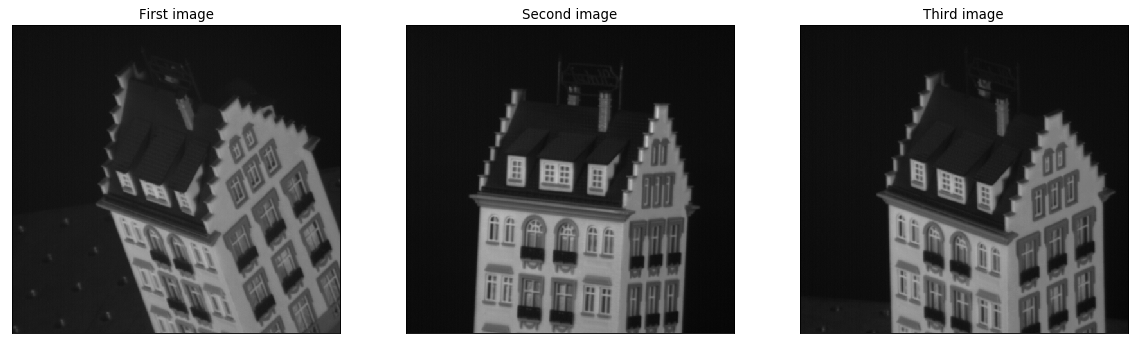

In [110]:
images = []
for image in os.listdir('./sfm_quiz7_images/'):
    images.append(cv2.imread('./sfm_quiz7_images/'+image))    
    
fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131),plt.imshow(images[0])
plt.title('First image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(images[1])
plt.title('Second image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(images[2])
plt.title('Third image'), plt.xticks([]), plt.yticks([])
plt.show()

In [111]:
####using harris
dst1 = cv2.cornerHarris(cv2.cvtColor(images[0], cv2.COLOR_BGR2GRAY),2,3,0.04)
dst2 = cv2.cornerHarris(cv2.cvtColor(images[1], cv2.COLOR_BGR2GRAY),2,3,0.04)
dst3 = cv2.cornerHarris(cv2.cvtColor(images[2], cv2.COLOR_BGR2GRAY),2,3,0.04)

####using orb
orb = cv2.ORB_create()
kp1, des1 = orb.detectAndCompute(images[0],None)
kp2, des2 = orb.detectAndCompute(images[1],None)
kp3, des3 = orb.detectAndCompute(images[2],None)

### ORB Keypoint Detection ###

In [112]:
def normalize_kps(kp):
    x, y = 0, 0
    normalized_kps = []
    for i in range(len(kp)):
        x, y = x + kp[i].pt[0], y + kp[i].pt[1]
    x, y = x/len(kp), y/len(kp) 
    for i in range(len(kp)):
        normalized_kps.append((kp[i].pt[0] - x,kp[i].pt[1] - y))
#         normalized_kps.append((x - kp[i].pt[0],y - kp[i].pt[1]))
    return normalized_kps,x,y
    
normalized_kp1,T_x1,T_y1 = np.array(normalize_kps(kp1))
normalized_kp2,T_x2,T_y2 = np.array(normalize_kps(kp2))
normalized_kp3,T_x3,T_y3 = np.array(normalize_kps(kp3))

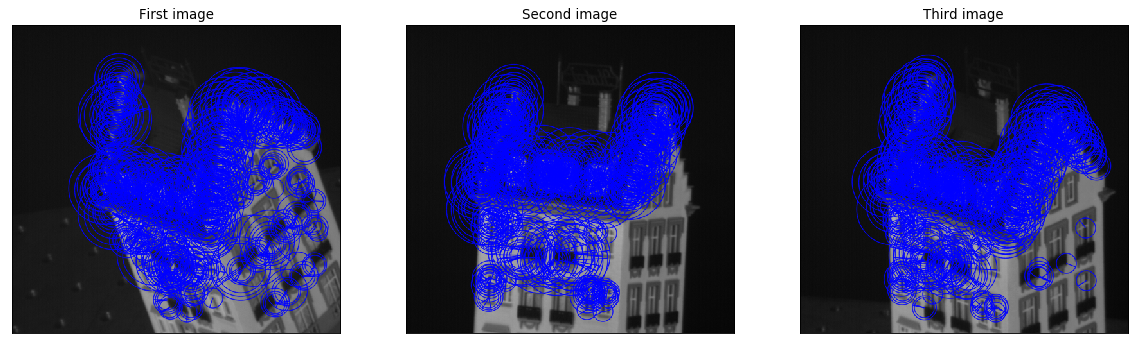

In [113]:
img_kp1 = cv2.drawKeypoints(images[0], kp1, outImage=np.array([]), color=(0, 0, 255),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp2 = cv2.drawKeypoints(images[1], kp2, outImage=np.array([]), color=(0, 0, 255),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
img_kp3 = cv2.drawKeypoints(images[2], kp3, outImage=np.array([]), color=(0, 0, 255),flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)


fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131),plt.imshow(img_kp1)
plt.title('First image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(img_kp2)
plt.title('Second image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(img_kp3)
plt.title('Third image'), plt.xticks([]), plt.yticks([])
plt.show()

### Brute Force Matching

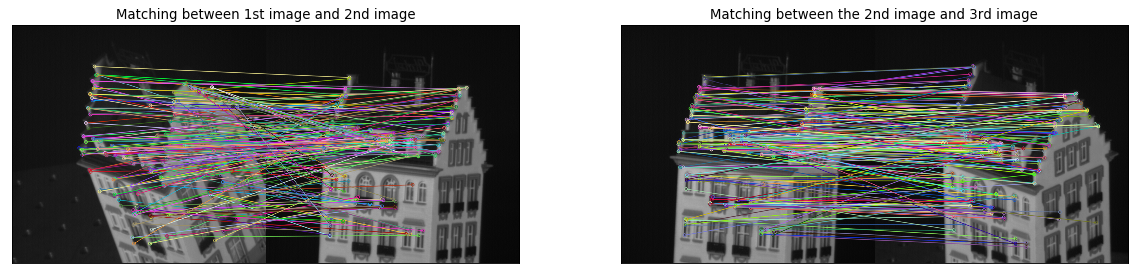

In [114]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches1 = bf.match(des1,des2)
# Sort them in the order of their distance.
matches1 = sorted(matches1, key = lambda x:x.distance)
# Draw first 10 matches.
img1 = cv2.drawMatches(images[0],kp1,images[1],kp2,matches1,None,flags=2)

matches2 = bf.match(des2,des3)
# Sort them in the order of their distance.
matches2 = sorted(matches2, key = lambda x:x.distance)
# Draw first 10 matches.
img2 = cv2.drawMatches(images[1],kp2,images[2],kp3,matches2,None,flags=2)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(121),plt.imshow(img1)
plt.title('Matching between 1st image and 2nd image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(img2)
plt.title('Matching between the 2nd image and 3rd image'), plt.xticks([]), plt.yticks([])
plt.show()

### Calculating W

In [115]:
W = []
for match in matches1:
    for m in matches2:
#         if match.queryIdx == m.trainIdx:
        if match.trainIdx == m.queryIdx:
#             column = [kp1[match.trainIdx].pt[0],kp2[match.queryIdx].pt[0],kp3[m.queryIdx].pt[0],
#                     kp1[match.trainIdx].pt[1],kp2[match.queryIdx].pt[1],kp3[m.queryIdx].pt[1]]
            column = [normalized_kp1[match.trainIdx][0],normalized_kp2[match.queryIdx][0],normalized_kp3[m.queryIdx][0],
                     normalized_kp1[match.trainIdx][1],normalized_kp2[match.queryIdx][1],normalized_kp3[m.queryIdx][1]]
            W.append(column)
W = np.array(W)
W = np.transpose(W)
W.shape

(6, 141)

### SVD of W

In [116]:
U, D, V = np.linalg.svd(W, full_matrices=True)
U_3 = U[:,0:3]
V_3 = V[0:3,:]
D_3 = np.eye(3)*D[0:3]
D_3_12 = np.abs(np.sqrt(D_3))

In [117]:
R = np.dot(U_3,D_3_12)
S = np.dot(D_3_12,V_3)

### Point Cloud

Point Cloud with Ŝ


<IPython.core.display.Javascript object>


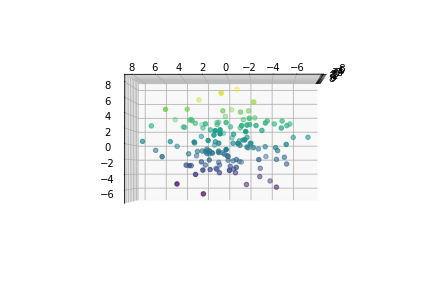

In [118]:
print("Point Cloud with Ŝ")
from mpl_toolkits import mplot3d
%matplotlib qt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(S[0], S[1], S[2], c=S[2]);

### Camera Positioning

Camera Motion R=(~RQ)


<IPython.core.display.Javascript object>


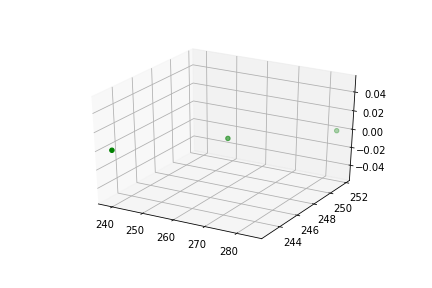

In [119]:
# %matplotlib inline
print("Camera Motion R=(~RQ)")
camera = [[T_x1,T_x2,T_x3],[T_y1,T_y2,T_y3],[0,0,0]]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(camera[0],camera[1],camera[2], color="g")
#plt.show()        

In [120]:
%matplotlib inline
def g_line(a,b):
    return [a[0]*b[0],a[0]*b[1]+a[1]*b[0],a[0]*b[2]+a[2]*b[0],a[1]*b[1],a[1]*b[2]+a[2]*b[1],a[2]*b[2]]
G = []
for i in range(3):
    G.append(g_line(R[i],R[i]))
for j in range(3):
    G.append(g_line(R[j+3],R[j+3]))
for i in range(3):
    G.append(g_line(R[i],R[i+3]))

c = np.array([1,1,1,1,1,1,0,0,0])

In [121]:
l = np.dot(np.linalg.pinv(G),c)
L = np.zeros((3,3))
L[0][0] = l[0]
L[0][1] = l[1]
L[0][2] = l[2]
L[1][0] = l[1]
L[1][1] = l[3]
L[1][2] = l[4]
L[2][0] = l[2]
L[2][1] = l[4]
L[2][2] = l[5]
print(L)

[[ 0.0031584   0.00013148 -0.00076371]
 [ 0.00013148  0.00015227  0.00093114]
 [-0.00076371  0.00093114  0.00072185]]


In [122]:
U,D,UT = np.linalg.cholesky(L)
U = np.reshape(U,(3,1))
D = np.reshape(D,(3,1))
# print(U.shape,D.shape,UT.shape)
D[np.where(D<0)] = 0.01
# print (U)
# print(U[1][0])
# print('----')
# print(D)
# print('----')
# print(UT)
U_f = np.eye(3)
# U_f[1][0] = U[0][0]
# U_f[2][0] = U[1][0]
# U_f[2][1] = U[2][0]
U_f[1][0] = UT[0]
U_f[2][0] = UT[1]
U_f[2][1] = UT[2]

D_f = np.eye(3)
# D_f[0][0] = D[0][0]
# D_f[1][1] = D[1][0]
# D_f[2][2] = D[2][0]
D_f[0][0] = UT[0]
D_f[1][1] = UT[1]
D_f[2][2] = UT[2]

# print('aaaaaaa')
# print (U_f)
# # print(U[1][0])
# print('----')
# print(D_f)
Q = np.dot(U_f,D_f)
# Q = np.dot(U_f,np.sqrt(D_f))
# print('------')
# print(Q)
Q1 = np.linalg.inv(Q)

LinAlgError: Matrix is not positive definite

In [123]:
R_final = np.dot(R,Q)
# S_final = np.dot(np.transpose(Q),S)
S_final = np.dot(Q1,S)

NameError: name 'Q' is not defined

### Point Cloud with $S=(Q^{-1}Ŝ)$

Point Cloud with S=(Q^{-1}Ŝ)


<IPython.core.display.Javascript object>


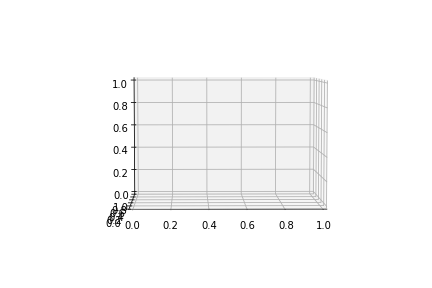

NameError: name 'S_final' is not defined

In [124]:
from mpl_toolkits import mplot3d
%matplotlib qt
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(S_final[0], S_final[1], S_final[2], c=S_final[2]);

print("Camera Motion R=(~RQ)")
camera = [[T_x1,T_x2,T_x3],[T_y1,T_y2,T_y3],[0,0,0]]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(camera[0],camera[1],camera[2], color="g")


### Harris Corner Detection ###

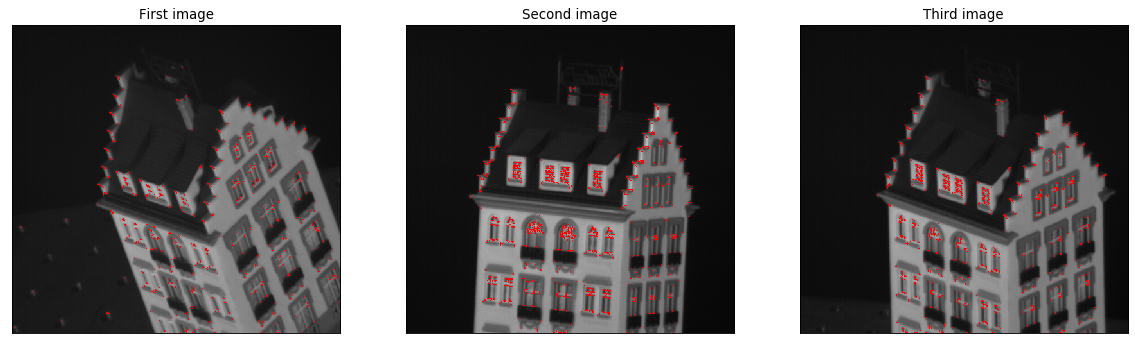

In [125]:
%matplotlib inline
imgcorners3 = images[2].copy()
# Threshold for an optimal value, it may vary depending on the image.
imgcorners3[dst3>0.01*dst3.max()]=[0,0,255]
imgcorners3 = cv2.cvtColor(imgcorners3, cv2.COLOR_BGR2RGB)
imgcorners2 = images[1].copy()
# Threshold for an optimal value, it may vary depending on the image.
imgcorners2[dst2>0.01*dst2.max()]=[0,0,255]
imgcorners2 = cv2.cvtColor(imgcorners2, cv2.COLOR_BGR2RGB)
imgcorners1 = images[0].copy()
# Threshold for an optimal value, it may vary depending on the image.
imgcorners1[dst1>0.01*dst1.max()]=[0,0,255]
imgcorners1 = cv2.cvtColor(imgcorners1, cv2.COLOR_BGR2RGB)

fig=plt.figure(figsize=(18, 16), dpi= 80, facecolor='w', edgecolor='k')
plt.subplot(131),plt.imshow(imgcorners1)
plt.title('First image'), plt.xticks([]), plt.yticks([])
plt.subplot(132),plt.imshow(imgcorners2)
plt.title('Second image'), plt.xticks([]), plt.yticks([])
plt.subplot(133),plt.imshow(imgcorners3)
plt.title('Third image'), plt.xticks([]), plt.yticks([])
plt.show()

In [126]:
corners1 = np.argwhere(imgcorners1==[0,0,255])
corners2 = np.argwhere(imgcorners2==[0,0,255])
corners3 = np.argwhere(imgcorners3==[0,0,255])

### Template Matching - Cross Correlation

In [127]:
matches1 = []
matches2 = []
matches3 = []
for corner in corners1:
    matches1.append([corner[0],corner[1]])
    template = imgcorners1[corner[0]:corner[0]+10,corner[1]:corner[1]+10,:]
    res2 = cv2.matchTemplate(imgcorners2,template,cv2.TM_CCORR)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res2)
    matches2.append([max_loc[0],max_loc[1]-10])
    res3 = cv2.matchTemplate(imgcorners3,template,cv2.TM_CCORR)
    min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res3)
    matches3.append([max_loc[0],max_loc[1]-10])


In [128]:
matches1 = np.array(matches1)
matches2 = np.array(matches2)
matches3 = np.array(matches3)

In [129]:
def normalize(matches):
    x,y = 0,0
    for m in matches:
        x = x + m[0]
        y = y + m[1]
    n_matches = []
    for m in matches:
        n_matches.append([m[0]-x,m[1]-y])
    return np.array(n_matches),x,y
nomr_points1,tx1,ty1 = normalize(matches1)
nomr_points2,tx2,ty2 = normalize(matches2)
nomr_points3,tx3,ty3 = normalize(matches3)

In [130]:
tx1

633019

In [131]:
print (len(nomr_points1),len(nomr_points2),len(nomr_points3))

2148 2148 2148


### Getting W

In [132]:
W = []
for i in range(len(nomr_points1)):
    column = [nomr_points1[i][0],nomr_points2[i][0],nomr_points3[i][0],
            nomr_points1[i][1],nomr_points2[i][1],nomr_points3[i][1]]
#     column = [matches1[i][0],matches2[i][0],matches3[i][0],
#             matches1[i][1],matches2[i][1],matches3[i][1]]
    W.append(column)
W = np.array(W)
W = np.transpose(W)
W.shape

(6, 2148)

### Getting R and S

In [133]:
U, D, V = np.linalg.svd(W, full_matrices=True)
U_3 = U[:,0:3]
V_3 = V[0:3,:]
D_3 = np.eye(3)*D[0:3]
D_3_12 = np.abs(np.sqrt(D_3))
R = np.dot(U_3,D_3_12)
S = np.dot(D_3_12,V_3)

### Point Cloud

Point Cloud with Ŝ


<IPython.core.display.Javascript object>


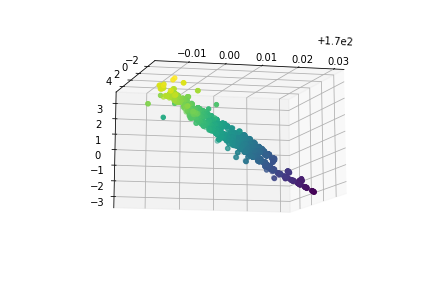

In [134]:
print("Point Cloud with Ŝ")
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(S[0], S[1], S[2], c=S[2]);

### Camera Positioning

633019
Camera Motion R=(~RQ)


<IPython.core.display.Javascript object>


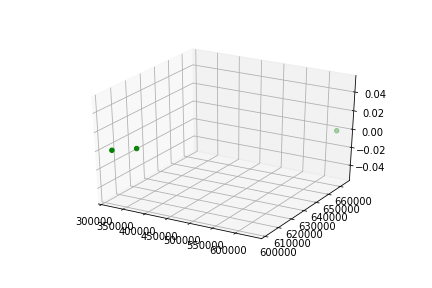

In [135]:
# %matplotlib inline
print(tx1)
print("Camera Motion R=(~RQ)")
camera = [[tx1,tx2,tx3],[ty1,ty2,ty3],[0,0,0]]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(camera[0],camera[1],camera[2], color="g")
# plt.show()        

In [102]:
%matplotlib inline
def g_line(a,b):
    return [a[0]*b[0],a[0]*b[1]+a[1]*b[0],a[0]*b[2]+a[2]*b[0],a[1]*b[1],a[1]*b[2]+a[2]*b[1],a[2]*b[2]]
G = []
for i in range(3):
    G.append(g_line(R[i],R[i]))
for j in range(3):
    G.append(g_line(R[j+3],R[j+3]))
for i in range(3):
    G.append(g_line(R[i],R[i+3]))

c = np.array([1,1,1,1,1,1,0,0,0])

l = np.dot(np.linalg.pinv(G),c)
L = np.zeros((3,3))
L[0][0] = l[0]
L[0][1] = l[1]
L[0][2] = l[2]
L[1][0] = l[1]
L[1][1] = l[3]
L[1][2] = l[4]
L[2][0] = l[2]
L[2][1] = l[4]
L[2][2] = l[5]
print(L)

[[ 1.98956560e-07 -4.31664042e-05 -7.33537351e-06]
 [-4.31664042e-05  1.65248683e-03 -4.80711164e-03]
 [-7.33537351e-06 -4.80711164e-03 -4.29692354e-03]]


In [136]:
U,D,UT = np.linalg.cholesky(np.abs(L))
U = np.reshape(U,(3,1))
D = np.reshape(D,(3,1))
# print(U.shape,D.shape,UT.shape)
D[np.where(D<0)] = 0.01
# print (U)
# print(U[1][0])
# print('----')
# print(D)
# print('----')
# print(UT)
U_f = np.eye(3)
# U_f[1][0] = U[0][0]
# U_f[2][0] = U[1][0]
# U_f[2][1] = U[2][0]
U_f[1][0] = UT[0]
U_f[2][0] = UT[1]
U_f[2][1] = UT[2]

D_f = np.eye(3)
# D_f[0][0] = D[0][0]
# D_f[1][1] = D[1][0]
# D_f[2][2] = D[2][0]
D_f[0][0] = UT[0]
D_f[1][1] = UT[1]
D_f[2][2] = UT[2]

# print('aaaaaaa')
# print (U_f)
# # print(U[1][0])
# print('----')
# print(D_f)
Q = np.dot(U_f,D_f)
# Q = np.dot(U_f,np.sqrt(D_f))
# print('------')
# print(Q)
Q1 = np.linalg.inv(Q)

U,D,UT = np.linalg.cholesky(L)
U = np.reshape(U,(3,1))
D = np.reshape(D,(3,1))
# print(U.shape,D.shape,UT.shape)
D[np.where(D<0)] = 0.01
# print (U)
# print(U[1][0])
# print('----')
# print(D)
# print('----')
# print(UT)
U_f = np.eye(3)
# U_f[1][0] = U[0][0]
# U_f[2][0] = U[1][0]
# U_f[2][1] = U[2][0]
U_f[1][0] = UT[0]
U_f[2][0] = UT[1]
U_f[2][1] = UT[2]

D_f = np.eye(3)
# D_f[0][0] = D[0][0]
# D_f[1][1] = D[1][0]
# D_f[2][2] = D[2][0]
D_f[0][0] = UT[0]
D_f[1][1] = UT[1]
D_f[2][2] = UT[2]

# print('aaaaaaa')
# print (U_f)
# # print(U[1][0])
# print('----')
# print(D_f)
Q = np.dot(U_f,D_f)
# Q = np.dot(U_f,np.sqrt(D_f))
# print('------')
# print(Q)
Q1 = np.linalg.inv(Q)

LinAlgError: Matrix is not positive definite

Point Cloud with S=(Q^{-1}Ŝ)


<IPython.core.display.Javascript object>


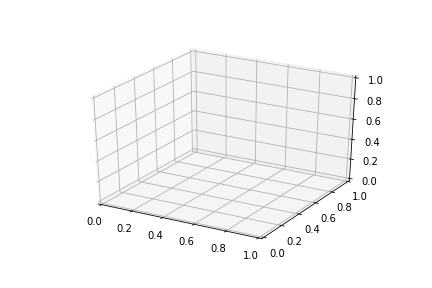

NameError: name 'S_final' is not defined

In [137]:
print("Point Cloud with S=(Q^{-1}Ŝ)")
from mpl_toolkits import mplot3d
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(S_final[0], S_final[1], S_final[2], c=S_final[2]);

print("Camera Motion R=(~RQ)")
camera = [[tx1,tx2,tx3],[ty1,ty2,ty3],[0,0,0]]
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(camera[0],camera[1],camera[2], color="g")